# Exercise 1: Fitting and finding minima of functions

For the atoms Ar2 in the Lennard-Jones potential energy:
Found epsilon best fit:  0.01368555991893374 eV
Found sigma best fit 3.4244817791207036 Angstroms
Using the Newton-Raphson root finding method, the stable equilibrium distance was 3.8437436618667173 Angstroms
It was found in 31 steps
And corresponds to a minimum potential of -0.013685559535874569 eV
And a minimum force of  7.14930290957184e-06 N


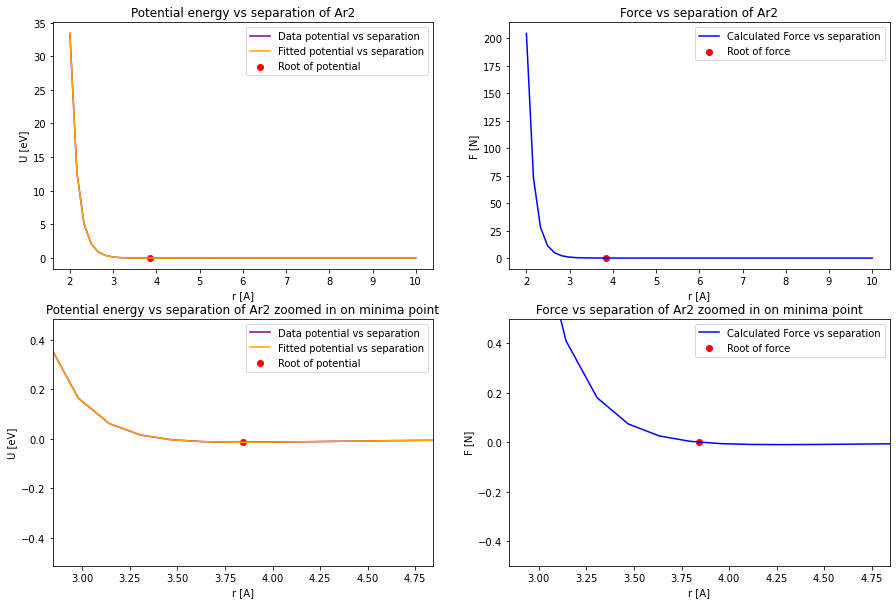

For the atoms He2 in the Lennard-Jones potential energy:
Found epsilon best fit:  0.004737271924839263 eV
Found sigma best fit 2.4059451906504665 Angstroms
Using the Newton-Raphson root finding method, the stable equilibrium distance was 2.7003243699007924 Angstroms
It was found in 26 steps
And corresponds to a minimum potential of -0.004737270369727196 eV
And a minimum force of  1.2068660507811252e-05 N


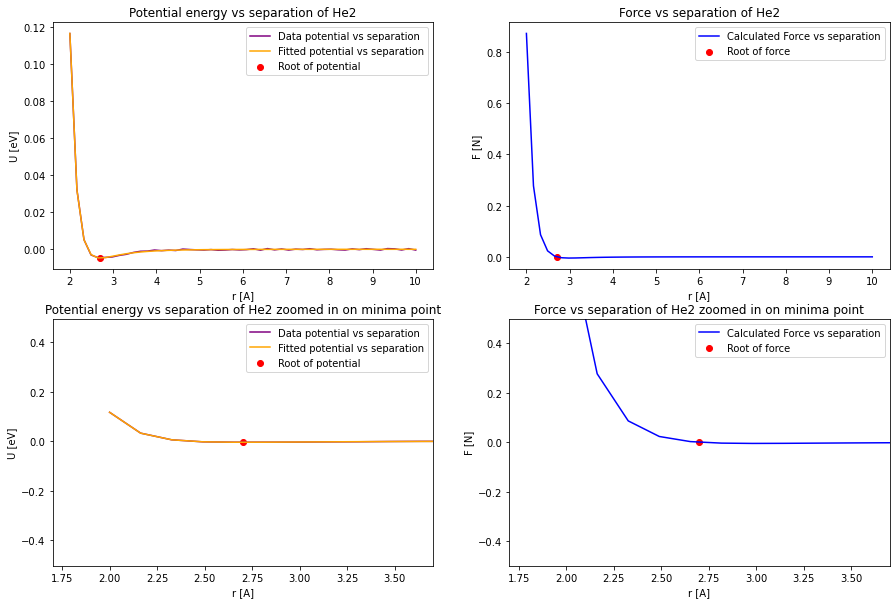

For the atoms Kr2 in the Lennard-Jones potential energy:
Found epsilon best fit:  0.01821630008882352 eV
Found sigma best fit 3.697729075828616 Angstroms
Using the Newton-Raphson root finding method, the stable equilibrium distance was 4.150419206682892 Angstroms
It was found in 32 steps
And corresponds to a minimum potential of -0.018216299328113895 eV
And a minimum force of  1.0765087477572301e-05 N


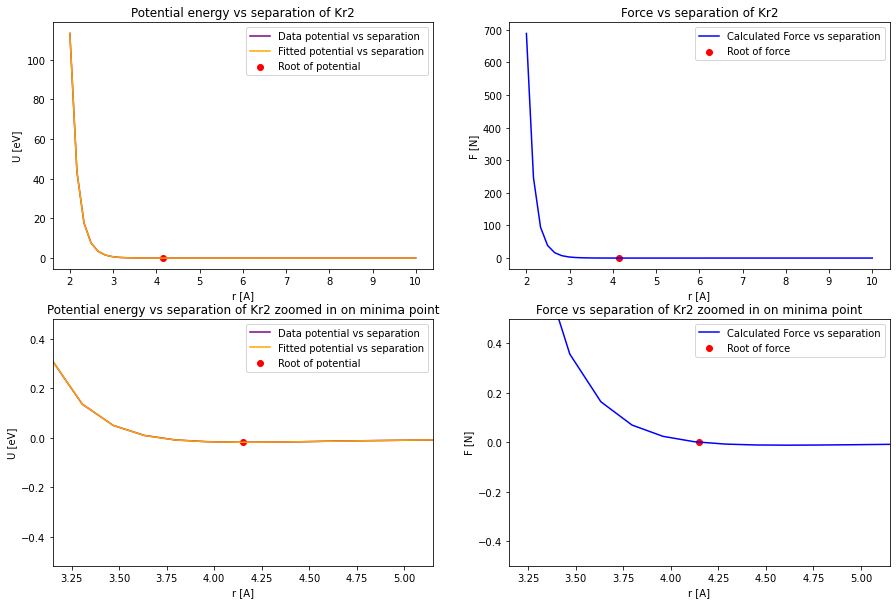

For the atoms Ne2 in the Lennard-Jones potential energy:
Found epsilon best fit:  0.008659464157656095 eV
Found sigma best fit 2.684766157807769 Angstroms
Using the Newton-Raphson root finding method, the stable equilibrium distance was 3.0135337960417625 Angstroms
It was found in 28 steps
And corresponds to a minimum potential of -0.008659464150612058 eV
And a minimum force of  9.83499050381533e-07 N


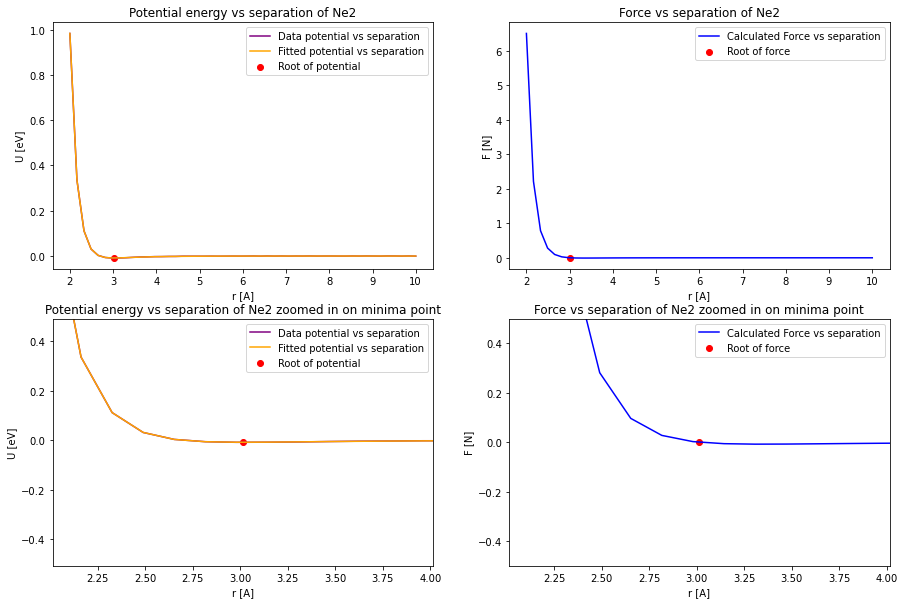

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

# CONSTANTS ========================================================================

#all the input files
files = [("Ar2", "potential_Ar2_QM.txt"), #with titles for display
        ("He2", "potential_He2_QM.txt"),
        ("Kr2", "potential_Kr2_QM.txt"),
        ("Ne2", "potential_Ne2_QM.txt")] #Collect filenames for use

data_frames = [] # You knew we were doing pandas.

# Newton-Rhapson constants
tol = 0.0001 #tolerances
r_initial = 0.5

# Curve-fitting constants
bounds = ([-np.inf, 2], [np.inf, np.inf]) # have to set bounds otherwise the curve fit does not work properly
# epsilon bounds are left of each list, sigma on right. So sigma 2<=sigma<=np.inf
# ^ the lack of bounds made me fight with this specific exercise for like 4 hours. RIP me

# FUNCTIONS ========================================================================

def Vr(r, epsilon, sigma):
    '''
    Computes the Lennard-Jones potential energy function for given r, epsilon and sigma
    Keyword Arguments:
        r         -- the distance between the atoms in question in Angstroms
        epsilon   -- the well-depth of the potential energy in eV
        sigma     -- the van der Waals radius of the two atoms
    returns:
        float -- the potential energy in eV calculated in the Lennard-Jones equation
    '''
    return 4*epsilon*np.power(sigma/r, 12) - 4*epsilon*np.power(sigma/r, 6)

def diffVr(r, epsilon, sigma):
    '''
    Computes the derivative with respect to r of Lennard-Jones potential energy 
    function for given r, epsilon and sigma
    NOTE: The negative of this function is Force.
    Keyword Arguments:
        r         -- the distance between the atoms in question in Angstroms
        epsilon   -- the well-depth of the potential energy in eV
        sigma     -- the van der Waals radius of the two atoms
    returns:
        float -- the change in potential energy of the calculation
    '''
    return 4*epsilon*(-12*np.power(sigma, 12)/np.power(r, 13) + 6*np.power(sigma, 6)/np.power(r, 7))

def diff2Vr(r, epsilon, sigma):
    '''
    Computes the second derivative with respect to r of Lennard-Jones potential energy 
    function for given r, epsilon and sigma
    Keyword Arguments:
        r         -- the distance between the atoms in question in Angstroms
        epsilon   -- the well-depth of the potential energy in eV
        sigma     -- the van der Waals radius of the two atoms
    returns:
        float -- the change in change in potential energy of the calculation
    '''
    return 4*epsilon*(156*np.power(sigma, 12)/np.power(r, 14) - 42*np.power(sigma, 6)/np.power(r, 8))

def Newton_Raphson(tol, r, e, s):
    '''
    Modified Newton Raphson algorithm to work with lamdify for the potential energy and derivative functions.
    Returns the minimum distance and the number of steps taken to find it.

    Keyword Arguments:
        tol -- recursion depth to go to
        r   -- initial guess to root
        e   -- function epsilon value
        s   -- function sigma value
    returns:
        (r, counts) -- returns tuple of found root and the number of iterations to get to it
    '''
    i=0
    while abs(diffVr(r, e, s)) > tol :
        i += 1
        r = r - (diffVr(r, e, s)/diff2Vr(r, e, s))
    return (r, i)

# MAGIC    ==========================================================================

#create dataframes for processing data
for title, file in files: #index is so we can grab what atom we're examining
    separation = []
    potential = [] 
    with open(file, 'r') as f: #pythonic, auto-closes file
        for line in f:
            cols = line.split() #separate on spaces
            separation.append(float(cols[0])) #two lists, both floats
            potential.append(float(cols[1])/1000) #converted to SI units here to prevent weird issues
            #and for better fitting
    #dataframes since we're working with 4 different atoms
    df = pd.DataFrame({"separation": separation, 
                        "potential": potential}) #2 column dataframes
    data_frames.append((title, df)) #make it a tuple of title and frame for ease of plotting

for title, df in data_frames: #since we have 4 atoms, all work + plotting done in for loop

    #Curve fit
    popt, _ = curve_fit(Vr, df["separation"], df["potential"], maxfev=5000, bounds=bounds) #fit the curve
    epsilon = popt[0] #names for readability
    sigma = popt[1] 

    # some discussion, will go into markdown cell
    print('For the atoms', title, 'in the Lennard-Jones potential energy:')
    print('Found epsilon best fit: ', epsilon, 'eV') #output for consolidation
    print('Found sigma best fit', sigma, 'Angstroms')

    #results from epsilon fitting
    df['fitted_curve'] = Vr(df['separation'], epsilon, sigma) #generate curve data from known r values
    df['force']        = -diffVr(df['separation'], epsilon, sigma) #force is -dVdr

    # #results from root finding
    r_min, counts = Newton_Raphson(tol, r_initial, epsilon, sigma)
    V_min = Vr(r_min, epsilon, sigma)
    F_min = -diffVr(r_min, epsilon, sigma) #force is -dVdr

    #some discussion, will go into markdown cell
    print('Using the Newton-Raphson root finding method, the stable equilibrium distance was', r_min, 'Angstroms')
    print('It was found in', counts, 'steps')
    print('And corresponds to a minimum potential of', V_min, 'eV')
    print('And a minimum force of ', F_min, 'N')

# PLOTS     ========================================================================
    fig, axes = plt.subplots(2, 2, figsize=(15,10)) #set up 2x2 for each atom pair
    #Potential curves and the fitted curves in the same plot
    df.plot(x='separation', y='potential', color='purple', label='Data potential vs separation', ax=axes[0, 0])
    df.plot(x='separation', y='fitted_curve', color='orange', label='Fitted potential vs separation', ax=axes[0, 0])
    axes[0, 0].scatter(r_min, V_min, color='red', label='Root of potential')
    axes[0, 0].set_xlabel('r [A]')
    axes[0, 0].set_ylabel('U [eV]')
    axes[0, 0].set_title('Potential energy vs separation of ' + title)
    axes[0, 0].legend()

    #Zoomed in potential curve 
    df.plot(x='separation', y='potential', color='purple', label='Data potential vs separation', ax=axes[1, 0])
    df.plot(x='separation', y='fitted_curve', color='orange', label='Fitted potential vs separation', ax=axes[1, 0])
    axes[1, 0].scatter(r_min, V_min, color='red', label='Root of potential')
    axes[1, 0].set_xlabel('r [A]')
    axes[1, 0].set_ylabel('U [eV]')
    axes[1, 0].set_xlim(r_min-1, r_min+1)
    axes[1, 0].set_ylim(V_min-0.5, V_min+0.5)
    axes[1, 0].set_title('Potential energy vs separation of ' + title + ' zoomed in on minima point')
    axes[1, 0].legend()

    #Force curves
    df.plot(x='separation', y='force', color='blue', label='Calculated Force vs separation', ax=axes[0, 1])
    axes[0, 1].scatter(r_min, F_min, color='red', label='Root of force')
    axes[0, 1].set_xlabel('r [A]')
    axes[0, 1].set_ylabel('F [N]')
    axes[0, 1].set_title('Force vs separation of ' + title)
    axes[0, 1].legend()

    #Zoomed in force curves
    df.plot(x='separation', y='force', color='blue', label='Calculated Force vs separation', ax=axes[1, 1])
    axes[1, 1].scatter(r_min, F_min, color='red', label='Root of force')
    axes[1, 1].set_xlabel('r [A]')
    axes[1, 1].set_ylabel('F [N]')
    axes[1, 1].set_xlim(r_min-1, r_min+1)
    axes[1, 1].set_ylim(F_min-0.5, F_min+0.5)
    axes[1, 1].set_title('Force vs separation of ' + title + ' zoomed in on minima point')
    axes[1, 1].legend()
    plt.show()

# Results

Graphs above detail the potential energy and force of each atom-atom pair based on curve fitting. We know the force is correct since it is the -dV/dr, however it is odd that it follows the same curve, approximately, as the potential.

I chose the curve_fit function to fit the Lennard-Jones reaction in scipi.optimize for its cleanliness, simplicity and ease of use, 
even though lacking bounds was frustrating for a long time.  The fit is good enough that the data is obscured by the fitted curve, which is ideal.

I also chose the Newton-Raphson method for finding roots in the reaction after the curves had been fitted. This was chosen due to its relative accuracy compared to the bisection method, which may have caused errors with this specific function. May as well go with the most robust solution if it's this easy to implement, after all.

The tolerance chosen for the Newton-Raphson was chosen to be 0.0001 for speed of runtime (we had 4 atom pairs and a lot to calculate). This was found to be sufficient in every case.

Using these we found, for each atom-pair in turn:


## Ar2
### Fitting:

epsilon = 0.014 eV,

sigma   = 3.42 A

### Newton-Raphson:

Steps to solution: 31,

Root (stable equilibrium): 3.84 A,

Potential at root: -0.013 eV,

Force between particles at root(error): 7.15e-06 N


## He2
### Fitting:

epsilon = 0.00474 eV,
sigma   = 2.700 A

### Newton-Raphson:

Steps to solution: 26,

Root (stable equilibrium): 2.70 A,

Potential at root: -0.0047 eV,

Force between particles at root(error): 1.21e-05 N,


## Kr2
### Fitting:

epsilon = 0.018 eV,
sigma   = 3.67 A

### Newton-Raphson:

Steps to solution: 32,

Root (stable equilibrium): 4.15 A,

Potential at root: -0.018 eV,

Force between particles at root(error): 1.07e-05 N

## Ne2
### Fitting:

epsilon = 0.0087 eV,
sigma   = 2.68 A

### Newton-Raphson:

Steps to solution: 28,

Root (stable equilibrium): 3.01 A,

Potential at root: -0.0087 eV,

Force between particles at root(error): 9.84e-07 N

